In [74]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime
import json

with open('transaction-data-adhoc-analysis.json','r') as t:
    data = json.load(t)

transaction_list = pd.DataFrame(data)

'''
ITEMS
'''
#Separating each transactional item into its own row
transaction_list['transaction_items'] = transaction_list['transaction_items'].str.split(";")
transaction_list = transaction_list.explode('transaction_items')

#Separating brand and quantity
transaction_list['transaction_items'] = transaction_list['transaction_items'].str.split(",")

transaction_list_split = pd.DataFrame(transaction_list['transaction_items'].to_list(), columns=['Brand', 'Item','Quantity'])

transaction_list = transaction_list.reset_index()

transaction_list = pd.concat([transaction_list, transaction_list_split],axis=1)

transaction_list = transaction_list.drop('transaction_items', axis=1)

#Extract int from quantity
transaction_list['Quantity'] = transaction_list['Quantity'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

'''
DATES
'''

#Converting dates to date time
transaction_list['transaction_date'] = pd.to_datetime(transaction_list['transaction_date'])
transaction_list['Month'] = pd.to_datetime(transaction_list['transaction_date']).dt.month
transaction_list['Year-Month'] = pd.to_datetime(transaction_list['transaction_date']).dt.strftime('%Y-%m')

'''
Item List with Price
'''

transaction_list1 = pd.DataFrame(data)

#Getting all items being sold in the store
single_type_items_receipt = transaction_list1[transaction_list1['transaction_items'].str.contains(";")==False]
single_item_transactions = single_type_items_receipt[single_type_items_receipt['transaction_items'].str.contains("x1")==True]
item_list_items = single_item_transactions['transaction_items'].unique()
item_list_price = single_item_transactions['transaction_value'].unique()

#Create new table for items
item_list_table = pd.DataFrame(list(zip(item_list_items,item_list_price)),columns=("Items Available","Price"))

#Separate by brand and quantity (CREATED item list)

item_list_table['Items Available'] = item_list_table['Items Available'].str.split(",")

item_list = pd.DataFrame(item_list_table['Items Available'].to_list(), columns=['Brand', 'Item','Quantity'])

item_list_table = pd.concat([item_list_table, item_list], axis=1)

item_list_table = item_list_table.drop("Items Available",axis=1)
item_list_table = item_list_table.drop("Quantity",axis=1)

item_list_table = item_list_table[['Brand', 'Item','Price']]

'''
Pivot Tables
'''

#Count of Each Item Sold Per Month
count_of_item_sold = transaction_list.pivot_table(values='Quantity', index = 'Item', 
                                                  columns= 'Year-Month', 
                                                  aggfunc= 'sum', fill_value = 0)

#Total sale value per item per month

sell = transaction_list.groupby(["Item","Year-Month"])["Quantity"].sum().reset_index(name="Quantity")

total_sale_value = sell.merge(item_list_table, on = "Item", how = "left")

total_sale_value = total_sale_value.drop("Brand", axis = 1)

total_sale_value

total_sale_value["Total Sale Value"] = np.where(total_sale_value.Price.isnull(),
                                                total_sale_value.Quantity,
                                                total_sale_value.Quantity*total_sale_value.Price)

total_sale_value_table = total_sale_value.pivot_table(values="Total Sale Value", index="Item",
                                                columns = "Year-Month", fill_value = 0)


#Repeaters, Inactive, Engaged
#Creating a list of unique customer transactions
customer_emails = transaction_list['mail'].unique()
customer_information = transaction_list.drop(["index","Brand","Item","Quantity"], axis = 1)
customer_information = customer_information.drop_duplicates(keep='first')
customer_information = customer_information.reset_index()

#Creating customer profiles that indicate whether a customer was active in the month

customer_monthly_activity = customer_information.drop(["index","transaction_value","transaction_date"], axis = 1)
customer_monthly_activity = customer_monthly_activity.drop_duplicates(keep='first')
customer_monthly_activity = customer_monthly_activity.reset_index()
customer_monthly_activity["Metric"] = 1
customer_monthly_activity = customer_monthly_activity.pivot_table(values = "Metric", 
                                                                  index = "mail", 
                                                                  columns = "Year-Month",
                                                                 fill_value = 0)

customer_monthly_activity_table = customer_monthly_activity.stack().reset_index()
customer_monthly_activity_table['Month'] = pd.to_datetime(customer_monthly_activity_table['Year-Month']).dt.month
customer_monthly_activity_table['Year'] = pd.to_datetime(customer_monthly_activity_table['Year-Month']).dt.year
customer_monthly_activity_table = customer_monthly_activity_table.rename(columns = {0:"Active"})

#GET max month
max_month_year = customer_monthly_activity_table["Year-Month"].max()
max_month = int(max_month_year[5:7])
max_year = int(max_month_year[0:4])

#GET min month
min_month_year = customer_monthly_activity_table["Year-Month"].min()
min_month = int(min_month_year[5:7])
min_year = int(min_month_year[0:4])

#GET months difference

month_diff = (max_year - min_year) * 12 + max_month - min_month

#Make sum of all months and last two months (based on current)
for index in range(0,len(customer_monthly_activity_table),month_diff+1):
    for month in range(1,month_diff+2):
        customer_monthly_activity_table.loc[index+month-1:index+month-1,"Month_no"] = month
        if customer_monthly_activity_table.loc[index+month-1:index+month-1,"Month"].item() == min_month and customer_monthly_activity_table.loc[index+month-1:index+month-1,"Year"].item() == min_year:
            customer_monthly_activity_table.loc[index+month-1:index+month-1,"last_two"] = 0
            customer_monthly_activity_table.loc[index+month-1:index+month-1,"all_months"] = 0

        else:
            customer_monthly_activity_table.loc[index+month-1:index+month-1,"all_months"] = customer_monthly_activity_table.loc[index:index+month-1,"Active"].sum()
            customer_monthly_activity_table.loc[index+month-1:index+month-1,"last_two"] = customer_monthly_activity_table.loc[index+month-2:index+month-1,"Active"].sum()

#Function for labels
def customer_activity (Month_no,Active,all_months,last_two):
    if last_two == 0 and all_months == 0:
            return "Others"
    else:
        if Active == 1: 
            if all_months == Month_no and last_two == 2:
                return "Engaged"
            elif last_two == 2 and all_months != Month_no:
                return "Repeaters"
            else:
                return "Others"
        else:
            return "Inactive"
        
customer_monthly_activity_table["Customer_Activity"] = np.vectorize(customer_activity)(customer_monthly_activity_table["Month_no"],
                                                                                       customer_monthly_activity_table["Active"],
                                                                                       customer_monthly_activity_table["all_months"],
                                                                                       customer_monthly_activity_table["last_two"])

customer_activity = customer_monthly_activity_table.drop(["all_months","Active","last_two","Month","Year","Month_no"],axis=1)
customer_activity = customer_activity.pivot_table(index=["Customer_Activity"],
                                                  columns=["Year-Month"],
                                                  aggfunc="count",
                                                  fill_value=0)

'''
ADDITIONAL TABLES/CHARTS
'''
#Table of count of item sold per month per brand
count_of_item_sold_brand = transaction_list.pivot_table(values='Quantity', index = 'Brand', 
                                                  columns= 'Year-Month', 
                                                  aggfunc= 'sum', fill_value = 0)

monthly_customer_info = customer_information.drop(["index","transaction_value","transaction_date"], axis = 1)
monthly_customer_info = monthly_customer_info.drop_duplicates(keep='first')
monthly_customer_info = monthly_customer_info.reset_index()

#Graph of total transactions per month
transactions_per_month = monthly_customer_info['Year-Month'].value_counts().sort_index()

#Gender Demographic
customer_info = customer_information.drop(["index","transaction_value","transaction_date","Month","address","birthdate","name"], axis = 1)
customer_info = customer_info.drop_duplicates(keep='first')

gender = customer_info['sex'].value_counts().sort_index()


### Count of Each Item Sold Per Month ###

In [75]:
count_of_item_sold

Year-Month,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06
Item,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902
Gummy Vitamins,9681,9980,10145,9842,9948,9980
Gummy Worms,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
Nutrional Milk,9727,9691,9876,9786,9881,9767
Orange Beans,9774,10037,9611,9914,9964,10106
Yummy Vegetables,9959,10256,9896,9861,9735,9722


### Total Sale Value Per Item Per Month ###

In [76]:
total_sale_value_table

Year-Month,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06
Item,,,,,,
Beef Chicharon,12554835,12991299,12750984,12847110,13026372,12862698
Gummy Vitamins,14521500,14970000,15217500,14763000,14922000,14970000
Gummy Worms,1433850,1499400,1497900,1506450,1470150,1490100
Kimchi and Seaweed,7731124,7949251,7963633,7926879,7808627,8073096
Nutrional Milk,19356730,19285090,19653240,19474140,19663190,19436330
Orange Beans,1945026,1997363,1912589,1972886,1982836,2011094
Yummy Vegetables,4979500,5128000,4948000,4930500,4867500,4861000


### Repeaters, Inactive, and Engaged for Each Month ###

In [77]:
customer_activity

mail                                        
Year-Month        2022-01 2022-02 2022-03 2022-04 2022-05 2022-06
Customer_Activity                                                
Engaged                 0    5275    4169    3304    2655    2159
Inactive                0    1525    1865    2031    2054    1964
Others               8835    2035    1639    1508    1544    1551
Repeaters               0       0    1162    1992    2582    3161

### Count of Item Sold Per Brand ###

In [78]:
count_of_item_sold_brand

Year-Month,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06
Brand,,,,,,
Candy City,19333,20033,19597,19957,19765,20040
Exotic Extras,19341,19950,19783,19811,19801,20006
HealthyKid 3+,29367,29927,29917,29489,29564,29469


### Transactions Per Month ###

(0.0, 7971.0)

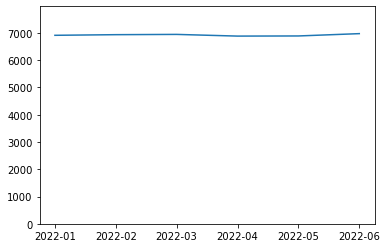

In [79]:
transactions_per_month.plot().set_ylim(bottom=0,top=transactions_per_month.max()+1000)

<AxesSubplot:>

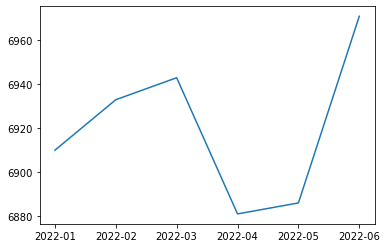

In [80]:
transactions_per_month.plot()

In [81]:
tpm_table = pd.DataFrame(transactions_per_month)
tpm_table

,Year-Month
2022-01,6910
2022-02,6933
2022-03,6943
2022-04,6881
2022-05,6886
2022-06,6971


### Demographic of Customers: Gender ###

<AxesSubplot:>

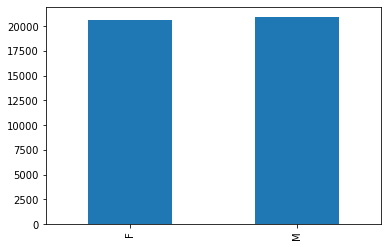

In [82]:
gender.plot.bar()

In [83]:
gender_table = pd.DataFrame(gender)
gender_table

,sex
F,20606
M,20918
